In [44]:
# !rm -rf data/ecgs.zarr
# !./ingest_ecg_records.py

In [110]:
SCORED_CODES = [
    270492004,
    164889003,
    164890007,
    426627000,
    713427006,
    713426002,
    445118002,
    39732003,
    164909002,
    251146004,
    698252002,
    10370003,
    284470004,
    427172004,
    164947007,
    111975006,
    164917005,
    47665007,
    59118001,
    427393009,
    426177001,
    426783006,
    427084000,
    63593006,
    164934002,
    59931005,
    17338001,
]

In [104]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import json
import scipy.signal as ss
from sklearn.preprocessing import normalize, MultiLabelBinarizer
from sklearn.neighbors import KernelDensity, LocalOutlierFactor

# store = zarr.DirectoryStore("data/ecgs.zarr")
# root = zarr.group(store=store, overwrite=False)
# root = zarr.open("data/ecgs.zarr")

root = zarr.open_group("data/ecgs.zarr", mode="r")
root.info

Name,/
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,4
No. arrays,0
No. groups,4
Groups,"beats, cleaned, meta, raw"


In [46]:
print(root.tree())

/
 ├── beats
 │   ├── r_peak_idxs (43099,) object
 │   ├── valid_r_peak_idxs (43099,) object
 │   ├── window_size_400 (43099,) object
 │   ├── window_size_400_normalized (43099,) object
 │   ├── window_size_400_normalized_flattened (801266, 400, 12) float32
 │   ├── window_size_400_outlier (43099,) int32
 │   └── window_size_400_shape (43099, 3) int32
 ├── cleaned
 │   └── p_signal (43099,) object
 ├── meta
 │   └── record_idx_to_window_400_range (1,) object
 └── raw
     ├── dx (43099,) object
     ├── meta (43099, 3) int32
     ├── p_signal (43099,) object
     └── p_signal_shape (43099, 2) int32


In [119]:
root["meta/record_idx_to_window_400_range"][0]["11721"]
# root["beats/window_size_400_normalized_flattened"][0]

[218912, 218923]

In [124]:
mlb = MultiLabelBinarizer(classes=SCORED_CODES)
# # mlb.fit([])
# print(dx)
# mlb.fit_transform([dx, ])

In [126]:
def get_signal(idx):
    signal = root["raw/p_signal"][idx].reshape(root["raw/p_signal_shape"][idx], order="C")
    cleaned_signal = root["cleaned/p_signal"][idx].reshape(root["raw/p_signal_shape"][idx], order="C")
    age, sex, fs = root["raw/meta"][idx]
    dx = root["raw/dx"][idx]
    
    beats = root["beats/r_peak_idxs"][idx]
    valid_beats = root["beats/valid_r_peak_idxs"][idx]

#     beat_windows = root["beats/window_size_400"][idx].reshape(root["beats/window_size_400_shape"][idx], order="C")
    beat_windows = root["beats/window_size_400_normalized"][idx].reshape(root["beats/window_size_400_shape"][idx], order="C")
    outlier = root["beats/window_size_400_outlier"][idx]
    bin_dx = mlb.fit_transform([dx,])

    return signal, cleaned_signal, age, sex, fs, dx, bin_dx, beats, valid_beats, beat_windows, outlier


/home/alexwong/miniconda3/envs/msc_research/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:994: UserWarning: unknown class(es) [164867002] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


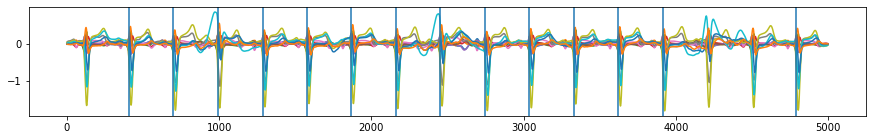

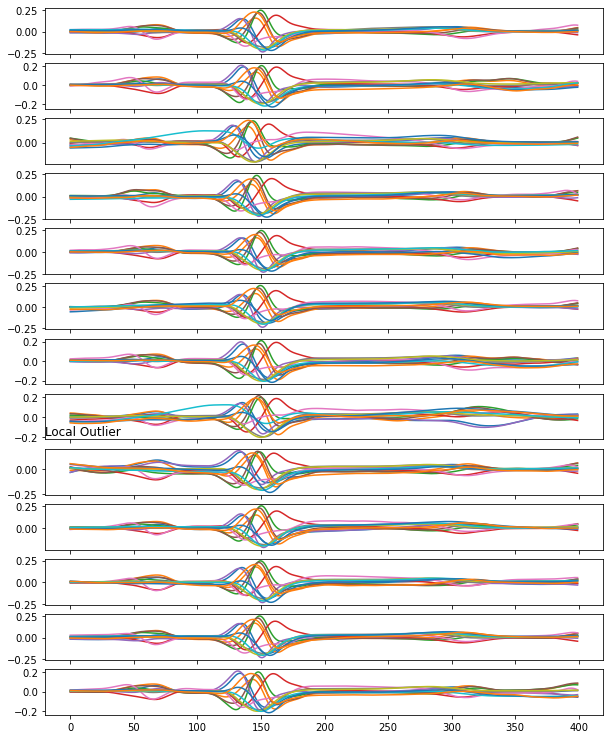

(5000, 12) 53 0 500 [164867002 427084000] (13, 400, 12) 7


(1, 27)

In [132]:
(
    signal,
    cleaned_signal,
    age,
    sex,
    fs,
    dx,
    bin_dx,
    beats,
    valid_beats,
    beat_windows,
    outlier
) = get_signal(0)#(43098)
# 384 uglllee


# plt.plot(signal)
# plt.show()
fig, axs = plt.subplots(1, figsize=(15, 2))
axs.plot(cleaned_signal)
# print(cleaned_signal.shape)
all_r_peaks_flat = np.concatenate(beats)[:, np.newaxis]
sig_range = np.linspace(0, all_r_peaks_flat.max(), len(cleaned_signal))[:, np.newaxis]
for sc in sig_range[valid_beats]:
    plt.axvline(x=sc)
plt.show()

# find outlier
# clf = LocalOutlierFactor(n_neighbors=len(beat_windows)//2)
# print(clf.fit_predict(beat_windows.reshape(len(beat_windows), -1)))
# print(clf.negative_outlier_factor_)
# outlier_idx = clf.negative_outlier_factor_.argmin()

fig, axs = plt.subplots(len(beat_windows), sharex=True, figsize=(10, len(beat_windows)))
for i in range(len(beat_windows)):
    if i == outlier:
        axs[i].set_title("Local Outlier", pad=0, y=0.1, loc="left")
    try:
        axs[i].plot(beat_windows[i])
    except TypeError:
        axs.plot(beat_windows[i])
    # axs[i].plot(normalize(valid_windows[i].T).T)
plt.show()

print(signal.shape, age, sex, fs, dx, beat_windows.shape, outlier)
# beat_windows[0]
bin_dx.shape

In [102]:
mlb = MultiLabelBinarizer()

### Normalized Windows Summary Stats

In [77]:
counter = {}
for idx, shape in enumerate(root[f"beats/window_size_{400}_shape"]):
    beat_len = shape[0]
    counter[beat_len] = counter.get(beat_len, []) + [idx,]
counter

{13: [0,
  6,
  25,
  32,
  35,
  43,
  55,
  74,
  95,
  105,
  114,
  121,
  128,
  134,
  145,
  160,
  190,
  200,
  201,
  202,
  210,
  218,
  224,
  227,
  230,
  271,
  312,
  336,
  347,
  353,
  370,
  372,
  385,
  389,
  398,
  407,
  417,
  419,
  428,
  441,
  468,
  471,
  478,
  479,
  485,
  498,
  536,
  538,
  541,
  542,
  577,
  580,
  592,
  597,
  613,
  617,
  620,
  631,
  635,
  662,
  671,
  706,
  713,
  714,
  732,
  735,
  737,
  746,
  767,
  771,
  783,
  784,
  828,
  829,
  830,
  887,
  889,
  894,
  909,
  915,
  916,
  921,
  922,
  941,
  949,
  959,
  973,
  976,
  1008,
  1032,
  1035,
  1045,
  1070,
  1079,
  1094,
  1096,
  1117,
  1130,
  1157,
  1158,
  1170,
  1186,
  1203,
  1212,
  1223,
  1228,
  1232,
  1245,
  1268,
  1276,
  1284,
  1294,
  1297,
  1312,
  1318,
  1333,
  1338,
  1352,
  1381,
  1407,
  1408,
  1421,
  1428,
  1432,
  1454,
  1455,
  1461,
  1462,
  1466,
  1478,
  1480,
  1498,
  1502,
  1514,
  1524,
  1539,
  1552,

In [98]:
# sorted(counter.keys())
counter[2]

[384, 1240, 1618]

In [99]:
# slow.
# from scipy.stats import describe
# desc = describe(root[f"beats/window_size_{400}_normalized_flattened"])
# d_min, d_max = desc.minmax
# print(min(d_min.flatten()), max(d_max.flatten()))

## Debugging

In [180]:
all_sparse_labels = mlb.fit_transform(root["raw/dx"][:])
# all_sparse_labels.shape
num_total, classes = all_sparse_labels.shape
positive = all_sparse_labels.sum(axis=0)
negative = num_total - positive
negative

label_weights = negative / positive
label_weights = label_weights / (max(label_weights) / 2)
label_weights  # label_weights.tolist()

array([0.1489851 , 0.09991316, 1.19393614, 1.30251308, 0.54416201,
       0.22565563, 0.20034472, 0.05328949, 0.35401128, 0.67045947,
       0.37002135, 1.25427218, 0.20965718, 2.        , 1.10196508,
       0.24083934, 0.36403858, 0.87565762, 0.14845971, 0.29579197,
       0.15132556, 0.00935373, 0.14845971, 1.74773682, 0.07205243,
       0.33084857, 1.02588786])

In [178]:
all_sparse_labels[:, 0].shape

(43099,)

In [134]:
# def _find_normalized_outlier(idx):
#     windows = root[f"beats/window_size_{window_size}"][idx].reshape(
#         root[f"beats/window_size_{window_size}_shape"][idx], order="C"
#     )
#     windows = np.nan_to_num(windows)
#     return np.transpose(np.stack(list(map(normalize, np.transpose(windows, axes=(0, 2, 1))))), axes=(0, 2, 1))
# beat_windows = _find_normalized_outlier(0)

# print(beat_windows.shape)

# fig, axs = plt.subplots(len(beat_windows), sharex=True, figsize=(10, len(beat_windows)))
# for i in range(len(beat_windows)):
#     if i == outlier_idx:
#         axs[i].set_title("Local Outlier", pad=0, y=0.1, loc="left")
#     axs[i].plot(beat_windows[i])
#     # axs[i].plot(normalize(valid_windows[i].T).T)
# plt.show()

In [ ]:
import tqdm
for i in tqdm.trange(43099):
    assert all(np.isfinite(root["cleaned/p_signal"][i])), i

[[501, 961, 1422, 1883, 2343, 2805, 3267, 3726, 4110, 4562, 4978, 5463, 5911, 6356, 6795, 7234, 7673], [501, 961, 1422, 1883, 2343, 2804, 3267, 3727, 4322, 4917, 5464, 5911, 6356, 6795, 7234, 7672], [432, 893, 1353, 1908, 2275, 2737, 3292, 3658, 4302, 4946, 5396, 5844, 6329, 6728, 7167, 7605, 7933], [474, 985, 1394, 1852, 2319, 2782, 3238, 3705, 4097, 4490, 4989, 5443, 5891, 6330, 6815, 7208, 7649], [501, 961, 1423, 1884, 2343, 2805, 3268, 3726, 4113, 4563, 4981, 5463, 5911, 6357, 6795, 7234, 7673], [433, 895, 1354, 1815, 2275, 2737, 3199, 3659, 4254, 4850, 5396, 5843, 6288, 6730, 7167, 7603], [485, 945, 1405, 1867, 2327, 2788, 3250, 3710, 4305, 4900, 5447, 5895, 6340, 6779, 7218, 7656], [490, 951, 1411, 1873, 2332, 2794, 3256, 3716, 4095, 4549, 4964, 5453, 5900, 6345, 6785, 7224, 7662], [492, 952, 1413, 1874, 2334, 2796, 3258, 3717, 4096, 4550, 4964, 5454, 5902, 6347, 6786, 7226, 7664], [495, 955, 1416, 1877, 2337, 2799, 3261, 3720, 4315, 4910, 5457, 5905, 6350, 6789, 7229, 7667], [49

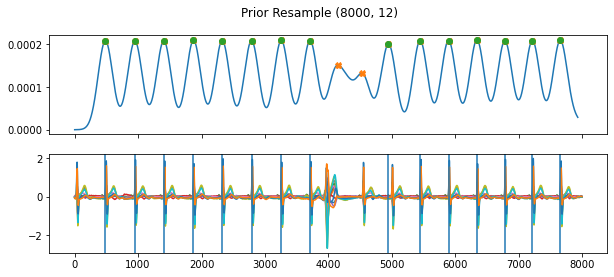

array([[[-0.04811921, -0.02422768,  0.02389153, ..., -0.05868241,
         -0.02749159, -0.0267933 ],
        [-0.04674379, -0.02343201,  0.02331181, ..., -0.05923831,
         -0.02933688, -0.02727577],
        [-0.04618227, -0.02340272,  0.02277956, ..., -0.05994412,
         -0.03143826, -0.02803482],
        ...,
        [-0.12673698, -0.11571099,  0.01102602, ..., -0.10687192,
         -0.0944643 , -0.11983877],
        [-0.1280701 , -0.11661279,  0.01145731, ..., -0.10798564,
         -0.09519902, -0.12051781],
        [-0.1288866 , -0.11698908,  0.01189748, ..., -0.1091092 ,
         -0.09597886, -0.12112991]],

       [[-0.08505137, -0.07732876,  0.00772256, ..., -0.05471296,
         -0.05253009, -0.080988  ],
        [-0.09488588, -0.08695262,  0.0079333 , ..., -0.05980618,
         -0.05714743, -0.08540531],
        [-0.10448342, -0.09619673,  0.00828668, ..., -0.06485464,
         -0.06185764, -0.08989944],
        ...,
        [-0.03816843, -0.01946503,  0.01870341, ..., -

In [70]:
import neurokit2 as nk
window_size = 400
def _generate_beats(idx):
    p_signal = root["cleaned/p_signal"][idx].reshape(
        root["raw/p_signal_shape"][idx], order="C"
    )
    _, _, fs = root["raw/meta"][idx]
    
    def nk_ecg_peaks(cleaned_signal, sampling_rate=fs):
        try:
            _, ecg_r_peaks_dict = nk.ecg_peaks(
                cleaned_signal,
                sampling_rate=sampling_rate,
                method="neurokit",
                correct_artifacts=True,
            )
            r_peaks = ecg_r_peaks_dict["ECG_R_Peaks"].tolist()
            return r_peaks
        except Exception:
            return []

    all_r_peaks = list(map(nk_ecg_peaks, p_signal.T))

    print(all_r_peaks)
    # Join all of the R-peaks into a single vector
    all_r_peaks_flat = np.concatenate(all_r_peaks)[:, np.newaxis]
    sig_range = np.linspace(0, all_r_peaks_flat.max(), len(p_signal))[:, np.newaxis]

    # Find the peaks with bandwidth proportional to rough mean RR
    mean_beats_detected = np.mean([len(r_peaks) for r_peaks in all_r_peaks])
    rough_meanrr = np.mean(
        [np.diff(r_peaks).mean() for r_peaks in all_r_peaks if len(r_peaks) >= 2 and len(r_peaks) >= mean_beats_detected]
    )
    kde = KernelDensity(bandwidth=rough_meanrr / 4).fit(all_r_peaks_flat)
#     kde = KernelDensity(bandwidth=5000).fit(all_r_peaks_flat)

    log_dens = kde.score_samples(sig_range)
    dens = np.exp(log_dens)
    peaks, _ = ss.find_peaks(dens)

    # keep only the peaks that are greater than thereshold density
    threshold_peak_density = dens[peaks].mean() - (2 * dens[peaks].std())
    valid_peaks = peaks[dens[peaks] > threshold_peak_density]

    # DISPLAY/DEBUG
    fig, axs = plt.subplots(2, sharex=True, figsize=(10, 4))
    axs[0].plot(sig_range[:, 0], dens)
    axs[0].plot(sig_range[peaks], dens[peaks], "X")
    axs[0].plot(sig_range[valid_peaks], dens[valid_peaks], "o")
    axs[1].plot(p_signal)
    fig.suptitle(f"Prior Resample {p_signal.shape}")
    for vpeak in sig_range[valid_peaks]:
        plt.axvline(x=vpeak)
    plt.show()

#     r_peak_idxs[idx] = all_r_peaks
#     valid_r_peak_idxs[idx] = valid_peaks

    # resample the signal such that the mean distance between
    # valid R-peaks is equal to `window_size`
    scaling_indicies = sig_range[valid_peaks].squeeze()
    scaling_indicies = np.insert(scaling_indicies, 0, 0)
    scaling_indicies = np.append(scaling_indicies, len(p_signal))
    peak_diff_dist = np.diff(scaling_indicies)
    mean_peak_diff_dist = peak_diff_dist.mean()
    resamp_to_len = (len(p_signal) / mean_peak_diff_dist) * window_size
    resamp_to_len = int(np.ceil(resamp_to_len))
    p_signal = ss.resample(p_signal, resamp_to_len)

    # resample the peaks so we don't have to calculate again
    scaling_factor = window_size / mean_peak_diff_dist
    upscaled_peak_diff_dist = peak_diff_dist * scaling_factor
    scaled_indicies = np.r_[scaling_indicies[0], upscaled_peak_diff_dist].cumsum()
    scaled_indicies = scaled_indicies[1:-1]

    # slice up the windows and return the new matrices
    valid_windows = []
    sc_loffset = window_size * 0.35
    for sc in scaled_indicies:
        left_offset = int(np.floor(sc - sc_loffset))
        scaled_window = p_signal[left_offset : left_offset + window_size]
        if len(scaled_window) != window_size:
            # ignore windows that don't fit into window size
            continue
        valid_windows.append(scaled_window)

    valid_windows = np.stack(valid_windows)
#     beat_windows[idx] = valid_windows.flatten(order="C")
#     beat_window_shapes[idx] = valid_windows.shape

    return valid_windows

_generate_beats(10) # good for figure
# _generate_beats(7)
# _generate_beats(29247) # really strange outputs

### SNOMED CODES

In [109]:
with open("data/snomed_ct_dx_map.json") as f:
    snomed_map = json.load(f)

for sc in SCORED_CODES:
    print(sc, ", #", snomed_map[str(sc)])


270492004 , # ['IAVB', '1st degree av block']
164889003 , # ['AF', 'atrial fibrillation']
164890007 , # ['AFL', 'atrial flutter']
426627000 , # ['Brady', 'bradycardia']
713427006 , # ['CRBBB', 'complete right bundle branch block']
713426002 , # ['IRBBB', 'incomplete right bundle branch block']
445118002 , # ['LAnFB', 'left anterior fascicular block']
39732003 , # ['LAD', 'left axis deviation']
164909002 , # ['LBBB', 'left bundle branch block']
251146004 , # ['LQRSV', 'low qrs voltages']
698252002 , # ['NSIVCB', 'nonspecific intraventricular conduction disorder']
10370003 , # ['PR', 'pacing rhythm']
284470004 , # ['PAC', 'premature atrial contraction']
427172004 , # ['PVC', 'premature ventricular contractions']
164947007 , # ['LPR', 'Prolonged PR interval']
111975006 , # ['LQT', 'prolonged qt interval']
164917005 , # ['QAb', 'qwave abnormal']
47665007 , # ['RAD', 'right axis deviation']
59118001 , # ['RBBB', 'right bundle branch block']
427393009 , # ['SA', 'sinus arrhythmia']
426177001